## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

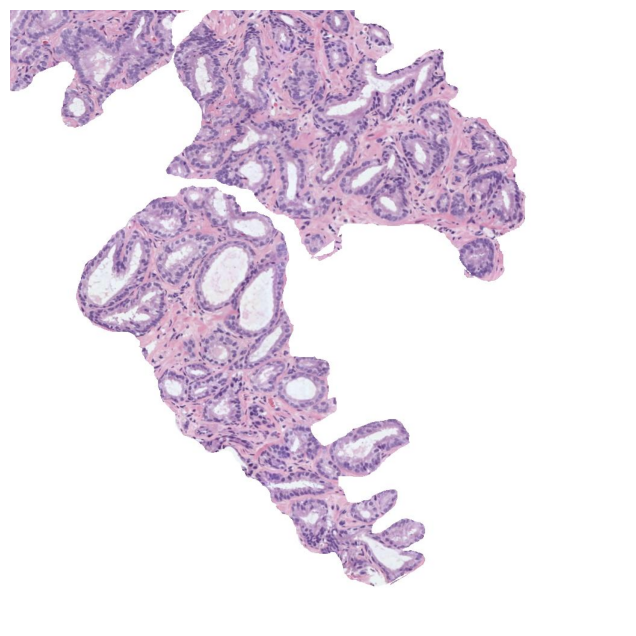

In [61]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
from skimage import io
import numpy as np
import matplotlib.pyplot as plt 

# Leer las imágenes
histoRGB = io.imread('histo_2.jpg')

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
MAX_RGB_VAL = 255
MIN_RGB_VAL = 0
histoRGB_normalized =  histoRGB.astype(float) / 255

# Visualizar la imagen
plt.figure(figsize=(10,8))
plt.imshow(histoRGB)
plt.axis('off')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

- Pillow para convertir la imagen a CMYK necesita que los valores esten entre [0-255], dado que anteriormente se solicita de manera explicita realizar una normalización, se entiende que no se quiere usar pillow. Se descarta esta opción.
- Tal y como se aprecia en https://scikit-image.org/docs/0.25.x/api/skimage.color.html#module-skimage.color, no se encuentra ninguna función en skimage que permita convertir una imagen RGB a CMYK, por lo que se implementa una función propia. Sigueindo la referencia de wikipedia: https://es.wikipedia.org/wiki/Modelo_de_color_CMYK#Mapeado_de_RGB_a_CMYK

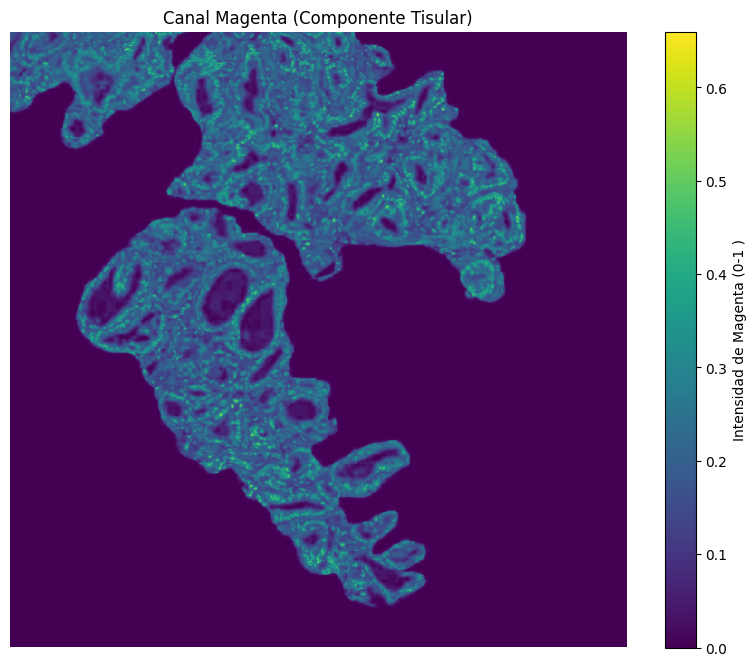

In [62]:
def rgb_to_cmyk_vectorized(rgb_img):
    """
    Convierte una imagen RGB (normalizada en [0, 1]) a CMYK usando operaciones de NumPy.
    Devuelve una única imagen CMYK de 4 canales.
    """
    # Extraer canales
    r = rgb_img[:, :, 0]
    g = rgb_img[:, :, 1]
    b = rgb_img[:, :, 2]

    k = 1 - np.maximum.reduce([r, g, b])

    # Evitar la división por cero para los píxeles que son completamente negros.
    c = np.where(k == 1, 0, (1 - r - k) / (1 - k))
    m = np.where(k == 1, 0, (1 - g - k) / (1 - k))
    y = np.where(k == 1, 0, (1 - b - k) / (1 - k))

    cmyk_img = np.stack([c, m, y, k], axis=-1)
    return cmyk_img

# Convertir la imagen normalizada a CMYK
cmyk_img = rgb_to_cmyk_vectorized(histoRGB_normalized)

# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Los canales CMYK están en el orden: C, M, Y, K
magenta_channel = cmyk_img[:, :, 1]

# Visualizar
plt.figure(figsize=(10, 8))
plt.imshow(magenta_channel)
plt.title('Canal Magenta (Componente Tisular)')
plt.axis('off')
plt.colorbar(label='Intensidad de Magenta (0-1 )') # La barra de color se ajustará al rango de CMYK de Pillow
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

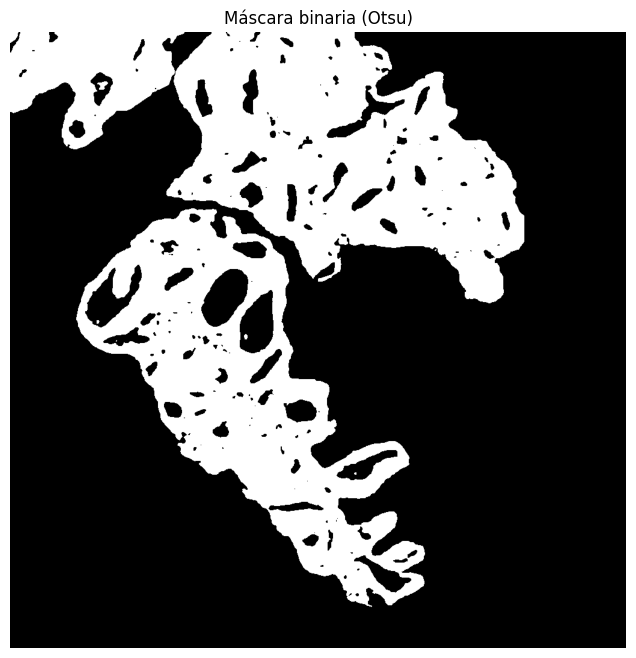

In [63]:
import cv2
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

magenta_uint8 = (magenta_channel * 255).astype(np.uint8)
kernel_size = (5, 5)
smoothed_image_cv2 = cv2.GaussianBlur(magenta_uint8 , kernel_size, 0)

_, mask_otsu = cv2.threshold(smoothed_image_cv2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(10, 8))
plt.imshow(mask_otsu, cmap='gray')
plt.title('Máscara binaria (Otsu)')
plt.axis('off')
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

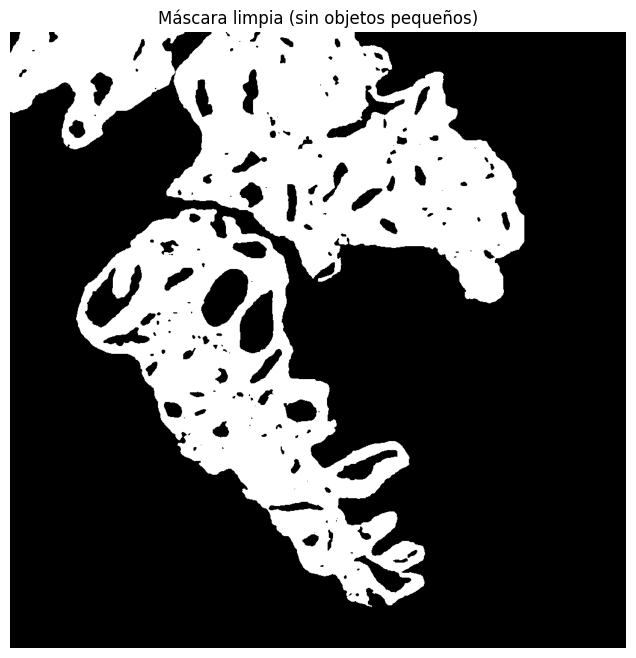

In [64]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
from skimage.morphology import remove_small_objects
mask_bool = mask_otsu.astype(bool)

# Eliminar objetos blancos pequeños (menos de 300 píxeles)
mask_clean = remove_small_objects(mask_bool, min_size=300)
plt.figure(figsize=(10, 8))
plt.imshow(mask_clean, cmap='gray')
plt.title('Máscara limpia (sin objetos pequeños)')
plt.axis('off')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [65]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

#### 5) Rellenar los objetos de los lúmenes

In [66]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [67]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

#### 7) Identificar y cropear el lumen más grande

In [68]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [69]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad